![](./images/Title.PNG)
<div class="alert alert-block alert-info"> <b> </b> 
</div>

![](./images/key_messages.PNG)

<div class="alert alert-block alert-info"> <b> </b> 
</div>

# Fraud detection from transactions
![](./images/workflow_fraud.PNG)

<div class="alert alert-block alert-info"> <b> </b> 
</div>

## 1 - Connect to Vantage
<div class="alert alert-block alert-info"> <b> </b> 
</div>

![](./images/Slide32.PNG)

In [1]:
import teradataml as tdml
tdml.options.configure.byom_install_location = "mldb"
tdml.display.print_sqlmr_query = False
import getpass
import json
tdml.__version__
from datetime import datetime
tic = datetime.now()
tdml.options.display
import matplotlib.pyplot as plt

In [2]:
tdml.__version__

'17.20.00.04'

In [3]:
Param = {
    'host'          : 'tdprd2.td.teradata.com', 
    'user'          : 'dm250067', 
    'password'      : "ENCRYPTED_PASSWORD(file:{},file:{})".format ('../../PassKey.properties','../../EncPass.properties'), #getpass.getpass(), 
    'logmech'       : 'LDAP',
    'database'      : 'ADLSLSEMEA_DEMO_BANKING',
    'temp_database_name' : 'dm250067'
    }

Param = {
    'host'          : 'tdprd3.td.teradata.com', 
    'user'          : 'dm250067', 
    'password'      : "ENCRYPTED_PASSWORD(file:{},file:{})".format ('../../PassKey.properties','../../EncPass.properties'), #getpass.getpass(), 
    'logmech'       : 'LDAP',
    'database'      : 'ADLDSD_CHURN',
    'temp_database_name' : 'dm250067'
    }

tdml.create_context(**Param)

C:\Users\dm250067\Anaconda3\envs\vantage39\lib\site-packages\teradataml\context\context.py:480: TeradataMlRuntimeWarning: Warning: Password is URL encoded.
  warnings.warn("Warning: Password is URL encoded.", category=TeradataMlRuntimeWarning)


Engine(teradatasql://:***@tdprd3.td.teradata.com/?DATABASE=ADLDSD_CHURN&LOGDATA=%2A%2A%2A&LOGMECH=%2A%2A%2A&USER=DM250067)

<div class="alert alert-block alert-info"> <b> </b> 
</div>

## 2 - Access to the data in S3

<div class="alert alert-block alert-info"> <b> </b> 
</div>

![](./images/Slide33.PNG)

In [4]:
print(tdml.execute_sql(f"SHOW TABLE {Param['database']}.transactions").fetchall()[0][0].replace('\r','\n'))

CREATE MULTISET TABLE ADLDSD_CHURN.transactions ,FALLBACK ,
     NO BEFORE JOURNAL,
     NO AFTER JOURNAL,
     CHECKSUM = DEFAULT,
     DEFAULT MERGEBLOCKRATIO,
     MAP = TD_MAP1
     (
      "type" VARCHAR(11) CHARACTER SET LATIN NOT CASESPECIFIC,
      txn_id INTEGER,
      step SMALLINT,
      amount FLOAT,
      nameOrig VARCHAR(17) CHARACTER SET LATIN NOT CASESPECIFIC,
      oldbalanceOrig FLOAT,
      newbalanceOrig FLOAT,
      nameDest VARCHAR(16) CHARACTER SET LATIN NOT CASESPECIFIC,
      oldbalanceDest FLOAT,
      newbalanceDest FLOAT,
      isFraud INTEGER,
      isFlaggedFraud BYTEINT,
      fold VARCHAR(1024) CHARACTER SET UNICODE NOT CASESPECIFIC)
PRIMARY INDEX ( txn_id );


In [5]:
data_in_vantage = tdml.DataFrame(tdml.in_schema(Param['database'], 'transactions'))
data_in_vantage

type,txn_id,step,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,fold
PAYMENT,1591203,331,638.67,C911592564,0.0,0.0,M2004122455,0.0,0.0,0,0,train
PAYMENT,15613105,191,1062.05,C679236405,13773.1,12711.05,M1067787043,0.0,0.0,0,0,train
PAYMENT,11577949,20,14186.24,C1617838015,25910.0,11723.76,M2069233476,0.0,0.0,0,0,test
PAYMENT,25599851,399,7166.69,C128448921,0.0,0.0,M360217065,0.0,0.0,0,0,test
PAYMENT,30605867,279,16907.32,C1511636986,0.0,0.0,M1848925734,0.0,0.0,0,0,test
PAYMENT,8598096,328,31006.12,C33819418,50136.11,19129.98,M473480222,0.0,0.0,0,0,test
CASH_OUT,16583965,328,205045.72,C1921200432,99437.0,0.0,C1311611285,821536.86,1026582.58,0,0,train
PAYMENT,24628991,9,8790.25,C614717252,0.0,0.0,M668667202,0.0,0.0,0,0,test
PAYMENT,10607089,297,7118.82,C881887893,50520.0,43401.18,M1532860588,0.0,0.0,0,0,test
PAYMENT,19622975,302,23922.27,C872553056,20543.0,0.0,M1875596235,0.0,0.0,0,0,test


In [6]:
%%time
print(data_in_vantage.sort('txn_id',ascending=False))

             type  step    amount     nameOrig  oldbalanceOrig  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  fold
txn_id                                                                                                                                                    
39636260  PAYMENT   213  30747.84  C1024145513            0.00            0.00   M912540236            0.00            0.00        0               0  test
39636259  CASH_IN   162  50526.30  C1008380691        10812.00        61338.30  C2036571882       566444.10       515917.80        0               0  test
39636258  CASH_IN   330  35150.54  C1434060405      2309839.84      2344990.38   C196157469       194034.48       158883.94        0               0  test
39636256  PAYMENT     7  14093.90  C1335472383            0.00            0.00   M531832315            0.00            0.00        0               0  test
39636254  PAYMENT   401  51597.53  C1347097118        25605.00        

In [7]:
%%time
print(data_in_vantage.sort('type',ascending=False))

              type  step      amount     nameOrig  oldbalanceOrig  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud   fold
txn_id                                                                                                                                                        
37595619  TRANSFER   136   460471.12   C701372857        36639.00            0.00   C292517117            0.00       460471.12        0               0   test
34623617  TRANSFER    19   196378.61   C827636631            0.00            0.00   C609610072       696285.18       892663.79        0               0   test
17599798  TRANSFER   131  1422343.12  C1024688446         8306.00            0.00   C242619213      1697571.42      3119914.54        0               0  train
22585626  TRANSFER   303  2424106.26   C269008577            0.00            0.00   C174750360      7816098.96     10240205.22        0               0   test
11582077  TRANSFER   687   326174.76  C1169787

In [8]:
data_in_vantage.columns

['type',
 'txn_id',
 'step',
 'amount',
 'nameOrig',
 'oldbalanceOrig',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud',
 'fold']

In [9]:
data_in_vantage.tdtypes

COLUMN NAME,TYPE
type,"VARCHAR(length=11, charset='LATIN')"
txn_id,INTEGER()
step,SMALLINT()
amount,FLOAT()
nameOrig,"VARCHAR(length=17, charset='LATIN')"
oldbalanceOrig,FLOAT()
newbalanceOrig,FLOAT()
nameDest,"VARCHAR(length=16, charset='LATIN')"
oldbalanceDest,FLOAT()
newbalanceDest,FLOAT()


In [10]:
data_in_vantage[['type']].squeeze(axis = 1).unique()

0    TRANSFER
1       DEBIT
2     PAYMENT
3    CASH_OUT
4     CASH_IN
Name: type, dtype: object

In [11]:
data_in_vantage[['fold','type','txn_id']].groupby(['fold','type']).count()

fold,type,count_txn_id
test,PAYMENT,409960
test,DEBIT,7680
train,DEBIT,3900
train,CASH_IN,131080
test,TRANSFER,100360
test,CASH_OUT,418480
train,TRANSFER,50720
test,CASH_IN,263520
train,CASH_OUT,209920
train,PAYMENT,204380


In [12]:
transaction_types = list(data_in_vantage[['type','txn_id']].groupby(['type']).count().to_pandas()['type'].values)
transaction_types

['CASH_IN', 'CASH_OUT', 'TRANSFER', 'PAYMENT', 'DEBIT']

<div class="alert alert-block alert-info"> <b> </b> 
</div>

## 3 - Machine Learning Pipeline Training

<div class="alert alert-block alert-info"> <b> </b> 
</div>

In [13]:
data_in_vantage_training = data_in_vantage[data_in_vantage.fold == 'train']
data_in_vantage_test     = data_in_vantage[data_in_vantage.fold == 'test']

In [14]:
print('data_in_vantage_training.shape :', data_in_vantage_training.shape)
print('data_in_vantage_test.shape :', data_in_vantage_test.shape)

data_in_vantage_training.shape : (600000, 13)
data_in_vantage_test.shape : (1200000, 13)


### 3.1 - OneHotEncoding of categorical variable "type"

![](./images/Slide34.PNG)

![](./images/Slide41.PNG)

In [15]:
transaction_types

['CASH_IN', 'CASH_OUT', 'TRANSFER', 'PAYMENT', 'DEBIT']

In [16]:
fit_obj = tdml.OneHotEncodingFit(data = data_in_vantage_training,
                            is_input_dense=True,
                            target_column='"type"',
                            categorical_values=transaction_types,
                            other_column="other")

In [17]:
obj = tdml.OneHotEncodingTransform(data=data_in_vantage_training,
                              object=fit_obj.result,
                              is_input_dense=True)
obj.result

type_CASH_IN,type_CASH_OUT,type_TRANSFER,type_PAYMENT,type_DEBIT,type_other,txn_id,step,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,fold
0,0,1,0,0,0,6612309,131,600401.99,C228384493,42097.0,0.0,C1848088955,0.0,600401.99,0,0,train
0,1,0,0,0,0,7625156,406,164107.97,C1282992478,51192.63,0.0,C571118141,249794.07,413902.04,0,0,train
0,0,1,0,0,0,8626869,129,12796.07,C2143889275,0.0,0.0,C700379447,124207.69,137003.76,0,0,train
1,0,0,0,0,0,7614022,308,100736.13,C1263108299,7727042.44,7827778.57,C1059922140,1602341.58,1501605.45,0,0,train
0,0,0,1,0,0,4591713,404,5574.54,C285399846,196.0,0.0,M637722727,0.0,0.0,0,0,train
0,0,0,1,0,0,3581415,354,6543.81,C23038280,0.0,0.0,M1624168387,0.0,0.0,0,0,train
0,1,0,0,0,0,1634128,130,108881.67,C1739539604,21267.0,0.0,C1378174410,0.0,108881.67,0,0,train
0,0,1,0,0,0,15577154,393,432958.83,C1282477979,432958.83,0.0,C1783092125,0.0,0.0,1,0,train
0,1,0,0,0,0,8604132,286,269050.49,C950612549,0.0,0.0,C1579001225,4221441.44,4490491.92,0,0,train
0,1,0,0,0,0,19581457,230,40980.28,C1283900774,0.0,0.0,C313773084,72187.68,113167.96,0,0,train


In [18]:
obj.result.max()

max_type_CASH_IN,max_type_CASH_OUT,max_type_TRANSFER,max_type_PAYMENT,max_type_DEBIT,max_type_other,max_txn_id,max_step,max_amount,max_nameOrig,max_oldbalanceOrig,max_newbalanceOrig,max_nameDest,max_oldbalanceDest,max_newbalanceDest,max_isFraud,max_isFlaggedFraud,max_fold
1,1,1,1,1,0,19636261,740,36012019.81,C999978091,33593209.9,33748554.09,M999930866,174582899.7,174743742.6,1,0,train


In [19]:
features  = ['amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_CASH_OUT', 'type_PAYMENT', 'type_CASH_IN', 'type_TRANSFER']
target    = 'isFraud'
id_column = 'txn_id'

In [20]:
ADS = obj.result[[id_column] +features + [target]]
ADS

txn_id,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_PAYMENT,type_CASH_IN,type_TRANSFER,isFraud
19590042,5499.25,0.0,0.0,0.0,0.0,0,1,0,0,0
15580172,146569.49,202479.0,55909.51,986690.88,1133260.37,1,0,0,0,0
7614022,100736.13,7727042.44,7827778.57,1602341.58,1501605.45,0,0,1,0,0
7625156,164107.97,51192.63,0.0,249794.07,413902.04,1,0,0,0,0
3581415,6543.81,0.0,0.0,0.0,0.0,0,1,0,0,0
8626869,12796.07,0.0,0.0,124207.69,137003.76,0,0,0,1,0
1634128,108881.67,21267.0,0.0,0.0,108881.67,1,0,0,0,0
10624728,3128.29,0.0,0.0,0.0,0.0,0,1,0,0,0
3631987,29886.18,0.0,0.0,0.0,0.0,0,1,0,0,0
4591713,5574.54,196.0,0.0,0.0,0.0,0,1,0,0,0


In [21]:
ADS.shape

(600000, 11)

In [22]:
ADS.tdtypes

COLUMN NAME,TYPE
txn_id,INTEGER()
amount,FLOAT()
oldbalanceOrig,FLOAT()
newbalanceOrig,FLOAT()
oldbalanceDest,FLOAT()
newbalanceDest,FLOAT()
type_CASH_OUT,INTEGER()
type_PAYMENT,INTEGER()
type_CASH_IN,INTEGER()
type_TRANSFER,INTEGER()


### 3.2 - Scaling of the data

![](./images/Slide35.PNG)

In [23]:
scaler = tdml.ScaleFit(
                    data=ADS,
                    target_columns=list(ADS.columns[1:6]),
                    scale_method="STD",
                    global_scale=False)

In [52]:
scaler.output

TeradataMlException: [Teradata][teradataml](TDML_2000) Failed to connect to Teradata Vantage.

TeradataMlException: [Teradata][teradataml](TDML_2000) Failed to connect to Teradata Vantage.

In [24]:
ADS_scaled = tdml.ScaleTransform(data=ADS,
                         object=scaler.output,
                         accumulate=[id_column, target]+list(ADS.columns[6:-1])).result
ADS_scaled = ADS_scaled[[id_column] +features + [target]]
ADS_scaled

txn_id,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_PAYMENT,type_CASH_IN,type_TRANSFER,isFraud
5585983,-0.3077432826711901,-0.2529197038308716,-0.25770964785044026,-0.3340922595525263,-0.3476100005485099,0,1,0,0,0
8613859,-0.07913749132085193,-0.2850164034588886,-0.28859083338422087,-0.29023104838869834,-0.26921566691655885,1,0,0,0,0
18628440,-0.2704305892543992,-0.2850164034588886,-0.28859083338422087,-0.3340922595525263,-0.3476100005485099,0,1,0,0,0
4586819,-0.3072514494942077,-0.26962636348464597,-0.27429742283228076,-0.31809577803835004,-0.33188805909141245,0,0,0,0,0
6632701,-0.08794666299695497,-0.27433356635126827,-0.23304667580294935,-0.3340922595525263,-0.3476100005485099,0,0,1,0,0
6624116,-0.25917449910887985,-0.28303838995916153,-0.28859083338422087,-0.3340922595525263,-0.3476100005485099,0,1,0,0,0
12581273,-0.26305007336194114,-0.2850164034588886,-0.28859083338422087,-0.3340922595525263,-0.3476100005485099,0,1,0,0,0
4615123,-0.3033628427349137,-0.247709305563784,-0.2534481344758548,-0.3340922595525263,-0.3476100005485099,0,1,0,0,0
12626278,0.35067995518977174,-0.2760101140983411,-0.28859083338422087,-0.3340922595525263,-0.24153986887064466,0,0,0,1,0
10633986,-0.30120693123197845,-0.2850164034588886,-0.28859083338422087,-0.3340922595525263,-0.3476100005485099,0,1,0,0,0


<div class="alert alert-block alert-info"> <b> </b> 
</div>

### 3.3 - Machine Learning Model Training : RandomForest training (in-database)

<div class="alert alert-block alert-info"> <b> </b> 
</div>

![](./images/Slide26.PNG)
![](./images/Slide36.PNG)

In [25]:
from teradataml import *

configure.database_version

'17.20.03.15'

ADS_scaled.to_sql(temporary=True, table_name = 'ADS_scaled',if_exists='replace')
ADS_scaled = tdml.DataFrame(tdml.in_schema(Param['user'] , 'ADS_scaled'))

In [26]:
training_stats = ADS_scaled[['isFraud','txn_id']].groupby('isFraud').count().to_pandas()
training_stats

,isFraud,count_txn_id
0,1,740
1,0,599260


<AxesSubplot: xlabel='isFraud'>

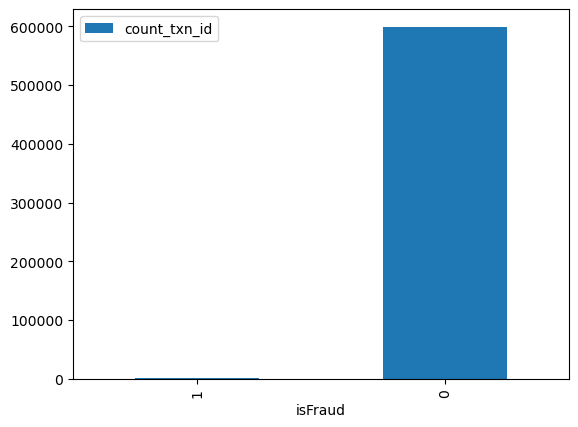

In [27]:
training_stats.plot(x='isFraud', y='count_txn_id',kind='bar')

In [28]:
ADS_scaled_training = ADS_scaled[ADS_scaled.isFraud == 1].concat(ADS_scaled[ADS_scaled.isFraud == 0].head(n=ADS_scaled[ADS_scaled.isFraud == 1].shape[0]))
ADS_scaled_training.show_query()

'select txn_id,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_PAYMENT,type_CASH_IN,type_TRANSFER,isFraud from (select * from "dm250067"."ml__select__1697474159686542" where "isFraud" = 1) as temp_table union all select txn_id,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_PAYMENT,type_CASH_IN,type_TRANSFER,isFraud from (select txn_id,amount,"oldbalanceOrig","newbalanceOrig","oldbalanceDest","newbalanceDest","type_CASH_OUT","type_PAYMENT","type_CASH_IN","type_TRANSFER","isFraud" from (select * from (select row_number() over (order by "txn_id" asc) - 1 as tdml_row_num, txn_id,amount,"oldbalanceOrig","newbalanceOrig","oldbalanceDest","newbalanceDest","type_CASH_OUT","type_PAYMENT","type_CASH_IN","type_TRANSFER","isFraud" from (select * from "dm250067"."ml__select__1697474159686542" where "isFraud" = 0) as temp_table) as temp_table where tdml_row_num < 740) as temp_table) as temp_table'

In [29]:
ADS_scaled_training.to_sql(table_name='ADS_scaled_training', schema_name=Param['database'], if_exists = 'replace', primary_index='txn_id')
ADS_scaled_training = tdml.DataFrame(tdml.in_schema(Param['database'], 'ADS_scaled_training'))

In [30]:
ADS_scaled_training.shape

(1480, 11)

In [31]:
training_stats = ADS_scaled_training[['isFraud','txn_id']].groupby('isFraud').count().to_pandas()
training_stats

,isFraud,count_txn_id
0,1,740
1,0,740


<AxesSubplot: xlabel='isFraud'>

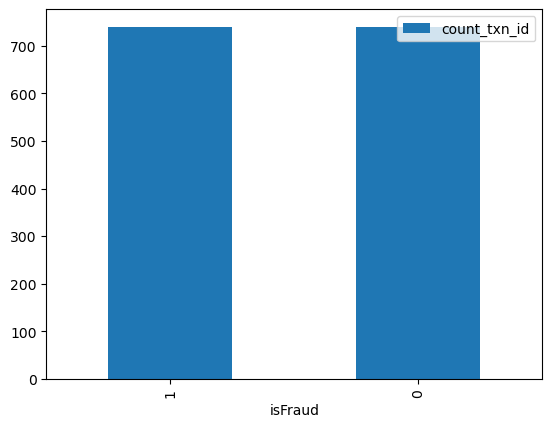

In [32]:
training_stats.plot(x='isFraud', y='count_txn_id',kind='bar')

In [33]:
DecisionForest_obj = tdml.DecisionForest(data = ADS_scaled_training, 
                            input_columns = features, 
                            response_column = target, 
                            max_depth = 15, 
                            num_trees = 72, 
                            min_node_size = 1, 
                            mtry = 6, 
                            mtry_seed = 1, 
                            seed = 1, 
                            tree_type = 'CLASSIFICATION')

In [34]:
DecisionForest_obj.result.to_sql("transaction_decision_forest_model", 
                                 schema_name=Param['database'], if_exists = "replace")

In [35]:
DF_DecisionForestModel  = tdml.DataFrame(
    tdml.in_schema(Param['database'],"transaction_decision_forest_model"))

In [36]:
DecisionForestPredict_obj = tdml.TDDecisionForestPredict(object = DF_DecisionForestModel,
                                                data = ADS_scaled_training,
                                                id_column = id_column,                                                        
                                                terms = ["isFraud"],
                                                output_prob = True,
                                                output_responses=["0","1"]
                                                )
DecisionForestPredict_obj.result.sort("prob")

txn_id,prediction,prob
576868,0,0.5
1608036,0,0.5
608036,0,0.5
576545,0,0.5
17608036,0,0.5
14608036,0,0.5
15608036,0,0.5
577538,0,0.5
6608036,0,0.5
576304,0,0.5


In [37]:
DecisionForestPredict_obj.result.groupby('prob').count().to_pandas().sort_values('prob')

,prob,count_txn_id,count_prediction
27,0.500000,26,26
20,0.513889,11,11
22,0.527778,8,8
6,0.541667,34,34
23,0.555556,14,14
26,0.569444,16,16
1,0.583333,42,42
31,0.597222,38,38
30,0.611111,68,68
28,0.625000,30,30


<div class="alert alert-block alert-info"> <b> </b> 
</div>

## 4 - Machine Learning Pipeline Scoring

<div class="alert alert-block alert-info"> <b> </b> 
</div>

### 4.1 - OneHotEncoding

![](./images/Slide37.PNG)

In [38]:
obj = tdml.OneHotEncodingTransform(data=data_in_vantage_test,
                              object=fit_obj.result,
                              is_input_dense=True)
ADS_scoring = obj.result[[id_column] +features + [target]]
ADS_scoring

txn_id,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_PAYMENT,type_CASH_IN,type_TRANSFER,isFraud
17590307,663.94,72671.06,72007.13,661545.63,662209.56,0,0,0,0,0
28598485,19077.41,0.0,0.0,0.0,0.0,0,1,0,0,0
35596793,2107.58,10654.0,8546.42,0.0,0.0,0,1,0,0,0
579967,6626.9,22128.0,15501.1,0.0,0.0,0,1,0,0,0
22627176,3949.31,31452.0,27502.69,0.0,0.0,0,1,0,0,0
630539,47077.98,0.0,0.0,76844.74,123922.71,1,0,0,0,0
31628910,12209.11,0.0,0.0,0.0,0.0,0,1,0,0,0
1626685,365169.04,118000.0,0.0,33412.03,36679.9,1,0,0,0,0
36609640,427435.68,0.0,0.0,1875036.2,2302471.88,0,0,0,1,0
37631072,33748.36,269164.31,235415.95,0.0,0.0,0,1,0,0,0


### 4.2 - Scaling

![](./images/Slide38.PNG)

In [39]:
ADS_scoring_scaled = tdml.ScaleTransform(data=ADS_scoring,
                         object=scaler.output,
                         accumulate=[id_column, target]+list(ADS.columns[6:-1])).result
ADS_scoring_scaled = ADS_scoring_scaled[[id_column] +features + [target]]
ADS_scoring_scaled

txn_id,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_PAYMENT,type_CASH_IN,type_TRANSFER,isFraud
23580193,-0.2905621127342167,-0.2850164034588886,-0.28859083338422087,-0.3340922595525263,-0.3476100005485099,0,1,0,0,0
37585394,-0.28263238225513854,-0.2795893089069774,-0.28859083338422087,-0.3340922595525263,-0.3476100005485099,0,1,0,0,0
17620018,-0.29693670058870336,-0.17448741228810952,-0.18247318385587152,-0.3340922595525263,-0.3476100005485099,0,1,0,0,0
4611432,0.2369621265782082,-0.1535409247799264,-0.04848606174713311,-0.1847200821294757,-0.295323412005315,0,0,1,0,0
10627277,-0.2909342806364333,2.0836619862663195,2.0533851495678355,-0.1607444139301894,-0.18829474450414188,0,0,1,0,0
39622222,-0.2555880999439135,-0.27931308380106656,-0.28859083338422087,-0.3340922595525263,-0.3476100005485099,0,1,0,0,0
29593489,-0.26196458946262957,-0.2850164034588886,-0.28859083338422087,-0.3340922595525263,-0.3476100005485099,0,1,0,0,0
36605949,-0.2934276066916313,-0.273513145791527,-0.28091366036603843,-0.3340922595525263,-0.3476100005485099,0,1,0,0,0
23608028,-0.2811860706531435,-0.2850164034588886,-0.28859083338422087,-0.3340922595525263,-0.3476100005485099,0,1,0,0,0
592508,0.040587502680324704,-0.02673411965358572,0.03717449907240988,-0.11871273312994668,-0.20194667558097734,0,0,1,0,0


### 5.2 - Machine Learning Model Scoring : trained RandomForest

![](./images/Slide27.PNG)
![](./images/Slide39.PNG)

In [40]:
DecisionForestPredict_obj = tdml.TDDecisionForestPredict(object = DF_DecisionForestModel,
                                                data = ADS_scoring_scaled,
                                                id_column = id_column,                                                        
                                                terms = ["isFraud"],
                                                output_prob = True,
                                                output_responses=["0","1"]
                                                )
DecisionForestPredict_obj.result

txn_id,prediction,prob
39605052,0,0.8472222222222222
35617450,0,0.8611111111111112
28633294,0,0.7777777777777778
27634599,0,0.875
32578440,0,0.6388888888888888
17596812,0,0.7083333333333334
19631560,0,0.8194444444444444
38588249,0,0.5277777777777778
39584395,0,0.8333333333333334
19625055,0,0.5972222222222222


In [41]:
DecisionForestPredict_obj.result.groupby('prediction').count()

prediction,count_txn_id,count_prob
0,1148600,1148600
1,51400,51400


In [42]:
DF_eval = DecisionForestPredict_obj.result.\
    join(other = ADS_scoring_scaled, on="txn_id", rsuffix="truth_").\
    select(["txn_id", "prediction", "prob", "isFraud"])
DF_eval

C:\Users\dm250067\AppData\Local\Temp\ipykernel_13008\3784931260.py:1: DeprecationWarning: 
Behaviour of the argument(s) "['lsuffix', 'rsuffix']" will change in future.
Use argument(s) "['lprefix', 'rprefix']" instead.
  DF_eval = DecisionForestPredict_obj.result.\


txn_id,prediction,prob,isFraud
39605052,0,0.8472222222222222,0
28633294,0,0.7777777777777778,0
19589573,0,0.8888888888888888,0
32578440,0,0.6388888888888888,0
25633722,0,0.9027777777777778,0
19622975,0,0.7638888888888888,0
19631560,0,0.8194444444444444,0
17596812,0,0.7083333333333334,0
3583495,0,0.7083333333333334,0
38588249,0,0.5277777777777778,0


In [43]:
DF_eval.tdtypes

COLUMN NAME,TYPE
txn_id,INTEGER()
prediction,INTEGER()
prob,FLOAT()
isFraud,INTEGER()


<div class="alert alert-block alert-info"> <b> </b> 
</div>

## 6 - Model Learning Pipeline Evaluation

<div class="alert alert-block alert-info"> <b> </b> 
</div>

![](./images/Slide40.PNG)

In [44]:
DF_eval.count(distinct=True)

count_txn_id,count_prediction,count_prob,count_isFraud
1200000,2,34,2


In [45]:
#help(tdml.ClassificationEvaluator)

In [46]:
# get evaluation metrics

tdml.ClassificationEvaluator(data=DF_eval, observation_column = "isFraud",prediction_column = "prediction", num_labels=2)


############ output_data Output ############

   SeqNum              Metric  MetricValue
0       3        Micro-Recall     0.958133
1       5     Macro-Precision     0.513143
2       6        Macro-Recall     0.915020
3       7            Macro-F1     0.514977
4       9     Weighted-Recall     0.958133
5      10         Weighted-F1     0.977389
6       8  Weighted-Precision     0.998560
7       4            Micro-F1     0.958133
8       2     Micro-Precision     0.958133
9       1            Accuracy     0.958133


############ result Output ############

       Prediction  Mapping  CLASS_1  CLASS_2  Precision    Recall        F1  Support
SeqNum                                                                              
0               0  CLASS_1  1148400      200   0.999826  0.958246  0.978594  1198440
1               1  CLASS_2    50040     1360   0.026459  0.871795  0.051360     1560


In [47]:
DF_eval_balanced = DF_eval[DF_eval.isFraud == 1].concat(DF_eval[DF_eval.isFraud == 0].head(n=DF_eval[DF_eval.isFraud == 1].shape[0]))

In [48]:
roc_out = tdml.ROC(probability_column="prob",
              observation_column="isFraud",
              positive_class="1",
              data=DF_eval_balanced)

# Print the result DataFrame.
print(roc_out.result)

              GINI
AUC               
0.618943  0.237886


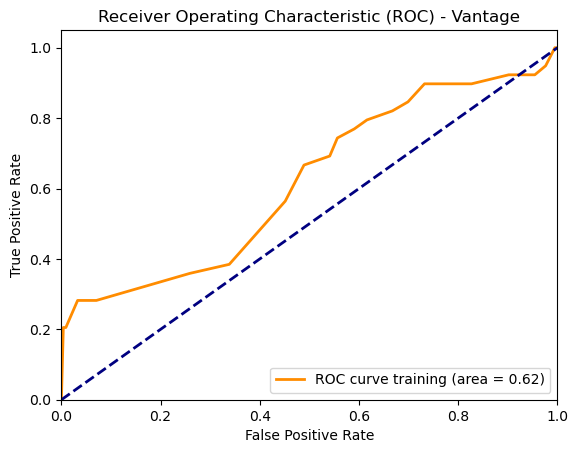

In [49]:
roc_test = roc_out.output_data.to_pandas()
plt.plot(roc_test.fpr,roc_test.tpr, color='darkorange', lw=2, label=f'ROC curve training (area = {roc_out.result.to_pandas().reset_index().AUC[0]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Vantage')
plt.legend(loc="lower right")

<div class="alert alert-block alert-info"> <b> </b> 
</div>

![](./images/Slide23.PNG)

In [50]:
tdml.remove_context()

True

In [51]:
toc = datetime.now()
print('elapsed time :', toc - tic,' seconds')

elapsed time : 0:03:55.861356  seconds
